# Time series analysis: A simple comparison

![timeseries_analysis](https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781801819626/files/Images/B17577_02_01.png)

Time-Series Analysis (TSA) is the process of extracting a summary and other statistical information from time-series, most importantly, the analysis of trend and seasonality.



When forecasting timeseries there are three main approaches you will encounter:

1. The statistical approach
2. The machine learning approach
3. The deep learning approach

In this notebook, we will focus on comparing the first two approaches through a simple example.

Note: The biggest difference between statistics and ML is their purposes. While statistical models are used for finding and explaining the relationships between variables, ML models are built for providing accurate predictions without explicit programming. 

Although some statistical models can make predictions, the accuracy of these models is usually not the best as they cannot capture complex relationships between data. On the other hand, ML models can provide better predictions, but it is more difficult to understand and explain them.

## Statistical (``Classical``) Approach

When you hear the term 'classical' time series approaches we are dealing with models that could be characterized as having a longer tradition, and are rooted in statistics and mathematics. 

They tend to have `stronger` assumptions on the properties of the data for example, many of the models assume stationarity. If a time-series is stationary (i.e. its mean and standard deviation stays constant over time).  Another important consideration is that most classical models are linear, which means they assume linearity in the dependencies between values at the same time and between values at different time steps. 

In the case, that this condition is not met, we'd have to preprocess our time-series to enforce stationarity to apply this approach. 

Thus, classical models are usually applied as follows:

* Test for stationarity
* Differencing [if stationarity detected]
* Fit method and forecast
* Add back the trend and seasonality

## Moving average and autoregression

Classical models can be grouped into families of models – moving averages (MA), autoregressive (AR) models, ARMA, and ARIMA. 

* In a **moving average**, the average (usually, the arithmetic mean) of values is taken over a specific number of time points (time frame) in the past. The moving average can smooth the trend and cycle over the history of a time-series; however, as a model, the moving average can be used to forecast into the future as well.

* An **autoregressive model (ARIMA)** regresses the variable on its own lagged values. In other words, the current value of the value is driven by immediately preceding values using a linear combination.

  As a reminder, ARIMA is parametrized with parameters p, d, q, where:

  * p is for the autoregressive model: AR(p)
  * d is for the integration
  * q is for the moving average: MA(q)

The **statsmodel** library can help to estimate statistical models and perform statistical tests. It's built on SciPy and NumPy and has lots of statistical functions and models.

#Example: Predicting Stock Prices

We'll work with a stock ticker dataset from Yahoo finance that we'll download through the yfinance library. We'll first load the dataset, do some quick exploration, and then we'll build several models. We'll load a series of Standard & Poor's depositary receipts (SPDR S&P 500 ETF Trust).

We have to indicate the date range and the ticker symbol. The daily prices come for Open, Close, and others. We'll work with the Open prices.



In [98]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
import statsmodels.api as sm
from datetime import datetime
import yfinance as yf
  
start_date = datetime(2005, 1, 1)
end_date = datetime(2021, 1, 1)
df = yf.download( 'SPY',
    start=start_date,
    end = end_date
)

[*********************100%***********************]  1 of 1 completed


It's always a good idea to visualize your data! Let's take a look.

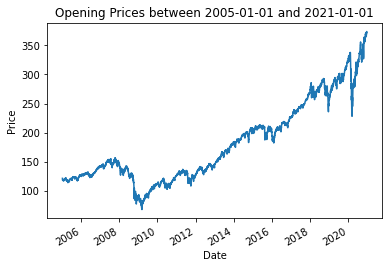

In [100]:
import matplotlib.pyplot as plt
plt.title('Opening Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df['Open'].plot()
plt.ylabel('Price')
plt.xlabel('Date');

Since this is daily data, and there are either 253 or 252 working days in the year, I've decided to resample the data to weekly data and make each year consistent. Some years have 53 weeks. We can't handle that, so we'll get rid of the 53rd week. We now have weekly data over 52 weeks across 16 years.

<ipython-input-101-28e13d5efc98>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1 = df1[df1.index.week < 53]


Date
2005-01-09    119.634000
2005-01-16    118.398000
2005-01-23    118.290001
2005-01-30    117.200000
2005-02-06    118.663998
Name: Open, dtype: float64

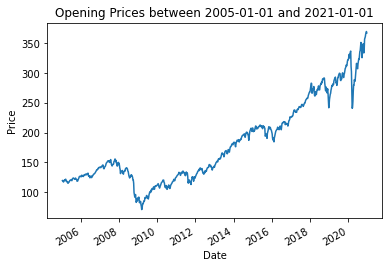

In [101]:
df1 = df.reset_index().resample('W', on="Date")['Open'].mean()
df1 = df1[df1.index.week < 53]
display(df1.head())

plt.title('Opening Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df1.plot()
plt.ylabel('Price')
plt.xlabel('Date');

One final fix: statsmodels can use the frequency information associated with the DateTimeIndex; however, this is often not set and df1.index.freq is None. So, we'll set it ourselves:

In [102]:
# To set the frequency to weekly we must fill any missing values (we'll use the foward fill method)
df1 = df1.asfreq('W').fillna(method='ffill')

# Check if we have effectively made our frequency into weekly.
print(df1.index.freq)

<Week: weekday=6>


Now we need to get some idea of reasonable ranges for the order of the model. We'll look at the autocorrelation and partial autocorrelation functions for this:

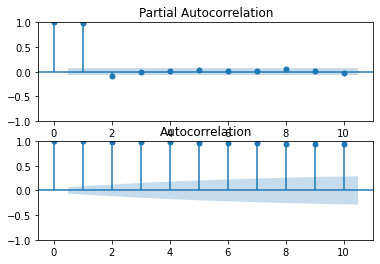

In [115]:
fig, axs = plt.subplots(2)
sm.graphics.tsa.plot_pacf(df1,method='ywm', lags=10, ax=axs[0])
sm.graphics.tsa.plot_acf(df1, lags=10, ax=axs[1])
plt.show()

These graphs show the correlation of the time-series with itself at lags of up to 20 time steps. 

* R or  values close to 0 mean that consecutive observations at the lags are not correlated with one another. 
* Inversely, correlations close to 1 or -1 indicate that there exists a strong positive or negative correlation between these observations at the lags.


We can see that the partial autocorrelation with lag 1 is very high and much lower for higher lags. The autocorrelation is significant and high for all lags, but the significance drops as the lag increases.

We can't use an autoregressive model straight off because it needs the time-series to be stationary, which means the mean and variance is constant over time – no seasonality, no trend.

We can use statsmodels utilities to look at seasonality and trend from the time-series:

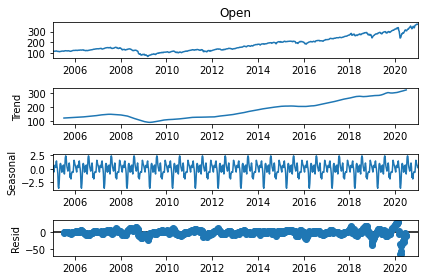

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df1, model='additive', period=52)
result.plot()
plt.show()

As discussed, we need a stationary series for modeling. To establish stationarity, we need to remove the seasonal and trend components. We could also take off the seasonal or trend components that we estimated just before. Alternatively, we can use wrapper functionality in statsmodels or set the d parameter in ARIMA.

We can use the Augmented Dickey-Fuller and KPSS tests to check for stationarity:

In [105]:
from statsmodels.tsa.stattools import adfuller as ADF
# To determine the amount of differencing needed, here d = 1.
print(ADF(df1))

mod = sm.tsa.arima.ARIMA(endog=df1, order=(1, 1, 0))
res = mod.fit()
print(res.summary())

(1.3246990005971708, 0.9967437094273013, 9, 824, {'1%': -3.438310908190086, '5%': -2.8650539530590673, '10%': -2.5686411274036196}, 4325.685952218077)
                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  834
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2211.813
Date:                Wed, 08 Mar 2023   AIC                           4427.626
Time:                        14:22:11   BIC                           4437.076
Sample:                    01-09-2005   HQIC                          4431.249
                         - 12-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3018      0.014     21.473      0.000     

This result summary gives all the key statistics. We see that the model was ARIMA(1, 1, 0). The [log-likelihood](https://www.statology.org/interpret-log-likelihood/) was -1965. We also see the [Bayesian Information Criterion](https://www.statology.org/bic-in-python/) and [Akaike Information Criterion](https://www.statology.org/aic-in-python/) values that we can use for model selection if we want.

### How can we use this model? Let's forecast the open price for 1 steps!

We will forecast 5 steps into the future and visualize our results. 

In [106]:
STEPS = 1
forecasts_df = res.get_forecast(steps=STEPS).summary_frame() 
display(forecasts_df)

Open,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-03,366.670056,3.442646,359.922593,373.417519


Not bad, try with different parameters. Interesting ones to change are the trend parameter and the order of the model and see how this affects your model. 

## ML Approach

Time series forecasting is also an important area of machine learning (ML) and can be cast as a supervised learning problem. ML methods such as Regression, Neural Networks, Support Vector Machines, Random Forests and XGBoost — can be applied to it. 

Different than the statistical methods previously discussed, 
before machine learning can be used, time series forecasting problems must be [re-framed as supervised learning problems]((https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/). 

We do so by creating features that capture the behaviour of the timeseries at previous 'time points' (i.e. adding lagged columns). 

Let's use the same dataset as before! Thankfully, we already explored the data a bit. We first need to featurize the data. Here, we'll do this by extracting date features.

You can do it manually or using transformers and creating a pipeline! Let's remind ourself how our data looks like!





In [127]:
import pandas as pd
open_df = pd.DataFrame(df1)
display(open_df.head())

,Open
Date,
2005-01-09,119.634000
2005-01-16,118.398000
2005-01-23,118.290001
2005-01-30,117.200000
2005-02-06,118.663998


In time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.

From our partial autocorrelation plot, we noticed that a lag of 1 relevant for our data. Let's create a `t-1` feature!



In [128]:
open_df['t-1'] = open_df['Open'].shift(1) #Note here that t-1 is one week before!
open_df.dropna(inplace=True)
display(open_df.head())

,Open,t-1
Date,,
2005-01-16,118.398000,119.634000
2005-01-23,118.290001,118.398000
2005-01-30,117.200000,118.290001
2005-02-06,118.663998,117.200000
2005-02-13,120.039999,118.663998


Now it's time to split the dataset into training and test sets. This includes two issues:

* We need to align the features with values ahead of time
* We need to split the dataset into two by a cutoff time

Let's first set the basic parameters for this. First, we want to predict into the future given a time horizon. Second, we need to decide how many data points we use for training and for testing.

Something to note here is that the train-test-split for time-series data is special. Because you cannot change the order of the table, you have to ensure that you don't sample randomly as you want your test data to contain points that are in the future from the points in the train data (time always moves forward).

In [129]:
train_size= int(len(open_df) * 0.8)
horizon = 1
forecast = "Open"

X_train, X_test = open_df.iloc[horizon:train_size], open_df.iloc[train_size+horizon:]
y_train = open_df.shift(periods=horizon).iloc[horizon:train_size][forecast]
y_test = open_df.shift(periods=horizon).iloc[train_size+horizon:][forecast]


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(665, 2) (166, 2)
(665,) (166,)


In [130]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [131]:
# make a one-step prediction
prediction = xgb.predict(X_test)

# This will return the same prediction for all sample in the test set (check that!) we just need one so we pick the first one
print(prediction[0])

252.83669


## Evaluation 
If we are interested in making a one-step forecast, e.g. one month, then we can evaluate the model by training on the training dataset and predicting the first step in the test dataset. We can then add the real observation from the test set to the training dataset, refit the model, then have the model predict the second step in the test dataset.

Repeating this process for the entire test dataset will give a one-step prediction for the entire test dataset from which an error measure can be calculated to evaluate the skill of the model. Read more: [How to Use XGBoost for Time Series Forecasting](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/).

## Final thoughts: How to choose the right approach?

Beyond the 'mathematical' properties of your data, this also depends on the importance of understanding the relationships between variables, and ultimately on the decisions to be taken.

You can apply statistical models when:

* You understand specific interaction effects between variables. You have prior knowledge about their relationships, for example, before you analyse weight and height, you know there is positive linear relationship between these two variables.
* Interpretability is important. You have to comply with strict regulations which requires you to understand exactly how the models work, especially when the decision affects a person’s life.
* Your data is small. 


You can apply ML when:

* High predictive accuracy is your goal. For example, if you work in an insurance company, you don’t want to accept a fraudster’s false claim and pay out in cash, so you want your predictive model on fraudulent claim to be as accurate as possible.
* Interpretability is less important. You do not care much about why a decision was made. Being able to understand the model is ideal, but not a must.
* Your data is big. You won’t be able to process the data in person. For example, individual patient’s charts and complex information about diagnoses, treatments, medications and more.

## Additional Resources

* [Machine Learning vs Statistical Modelling: which one is right for your business problem?](https://www.turintech.ai/machine-learning-vs-statistical-modelling-which-one-is-right-for-your-business-problem/) 